# Image Generation

In [1]:
!pip install -U diffusers[training] #in case collab resets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from huggingface_hub import notebook_login

notebook_login()

!sudo apt -qq install git-lfs
!git config --global credential.helper store

git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [3]:
from diffusers import UNet2DModel, DDPMScheduler


model = UNet2DModel.from_pretrained("otausendschoen/ddpm-eurosat-claudia").to("cuda")


noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise_scheduler.set_timesteps(250)  # Sample using only 200 steps!

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

## Creating the Images, Inspecting quality

In [4]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def generate_class_conditional_images(model, noise_scheduler, class_labels, image_size=64, seed=42):
    model.eval()
    batch_size = len(class_labels)
    generator = torch.Generator(device="cuda").manual_seed(seed)

    x = torch.randn(batch_size, 3, image_size, image_size, device="cuda", generator=generator)
    ##REVERSE DIFFUSION:
#new loop with few timesteps
    for t in noise_scheduler.timesteps:
      timesteps = torch.full((batch_size,), t, device="cuda", dtype=torch.long)
      with torch.no_grad():
        noise_pred = model(x, timesteps, class_labels=class_labels).sample
      x = noise_scheduler.step(noise_pred, t, x).prev_sample
    return (x / 2 + 0.5).clamp(0, 1)  # return denormalized images

'''
#old loop with original timestpes
    timesteps = torch.full((batch_size,), noise_scheduler.config.num_train_timesteps - 1, device="cuda", dtype=torch.long)#initializes the timesteps for all images as a torch array. eg (tensor([999, 999, 999, 999, 999, 999, 999, 999], device='cuda:0'))

    for t in range(noise_scheduler.config.num_train_timesteps - 1, -1, -1): #loop through all timesteps, starting from intiial timestep(-1 to go backward)
        timesteps.fill_(t) #creates the tensore filled with the current timesteps so basically the same as above
        with torch.no_grad():
            noise_pred = model(x, timesteps, class_labels=class_labels).sample
        x = noise_scheduler.step(noise_pred, t, x).prev_sample
    return (x / 2 + 0.5).clamp(0, 1)  # return denormalized images
'''


'\n#old loop with original timestpes\n    timesteps = torch.full((batch_size,), noise_scheduler.config.num_train_timesteps - 1, device="cuda", dtype=torch.long)#initializes the timesteps for all images as a torch array. eg (tensor([999, 999, 999, 999, 999, 999, 999, 999], device=\'cuda:0\'))\n\n    for t in range(noise_scheduler.config.num_train_timesteps - 1, -1, -1): #loop through all timesteps, starting from intiial timestep(-1 to go backward)\n        timesteps.fill_(t) #creates the tensore filled with the current timesteps so basically the same as above\n        with torch.no_grad():\n            noise_pred = model(x, timesteps, class_labels=class_labels).sample\n        x = noise_scheduler.step(noise_pred, t, x).prev_sample\n    return (x / 2 + 0.5).clamp(0, 1)  # return denormalized images\n'

**800 Steps**

🕒 800 steps: Image generation took 73.31 seconds (1.22 minutes)


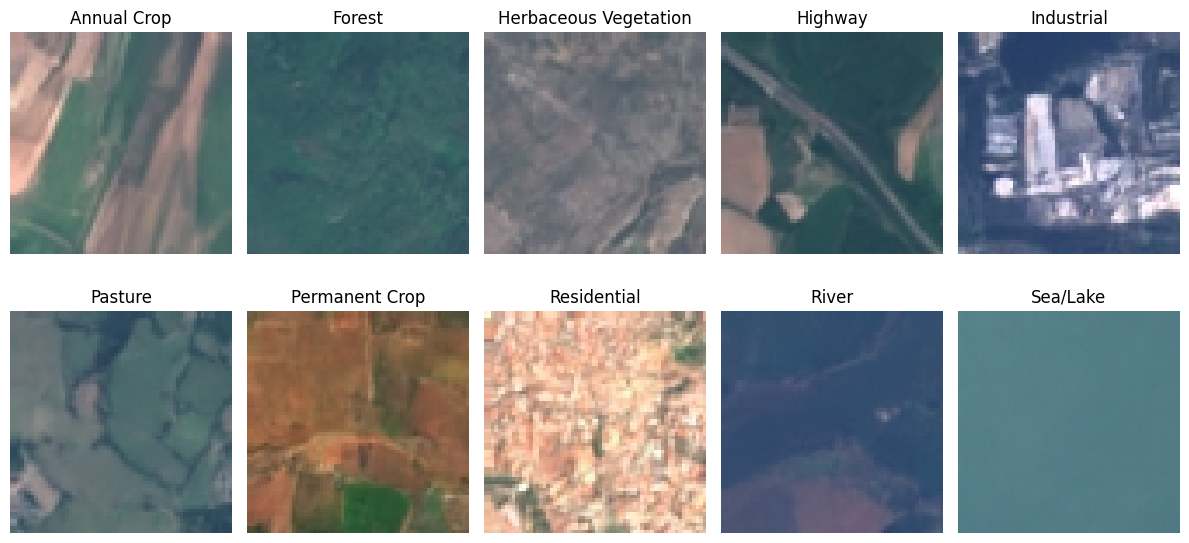

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import time
# Assuming the model + scheduler and generate_class_conditional_images() are set up
noise_scheduler.set_timesteps(800)  # Sample using only 200 steps!



labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device="cuda")


start_time = time.time()
images = generate_class_conditional_images(model, noise_scheduler, class_labels=labels)
end_time = time.time()

elapsed = end_time - start_time
print(f" 800 steps: Image generation took {elapsed:.2f} seconds ({elapsed / 60:.2f} minutes)")#

batch_size = len(labels)



eurosat_classes = [
    "Annual Crop", "Forest", "Herbaceous Vegetation", "Highway",
    "Industrial", "Pasture", "Permanent Crop", "Residential",
    "River", "Sea/Lake"
]

fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i in range(batch_size):
    img = transforms.ToPILImage()(images[i].cpu())
    class_name = eurosat_classes[labels[i].item()]
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(class_name)
    axs[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()



**500 Steps**

🕒 500 timesteps: Image generation took 45.04 seconds (0.75 minutes)


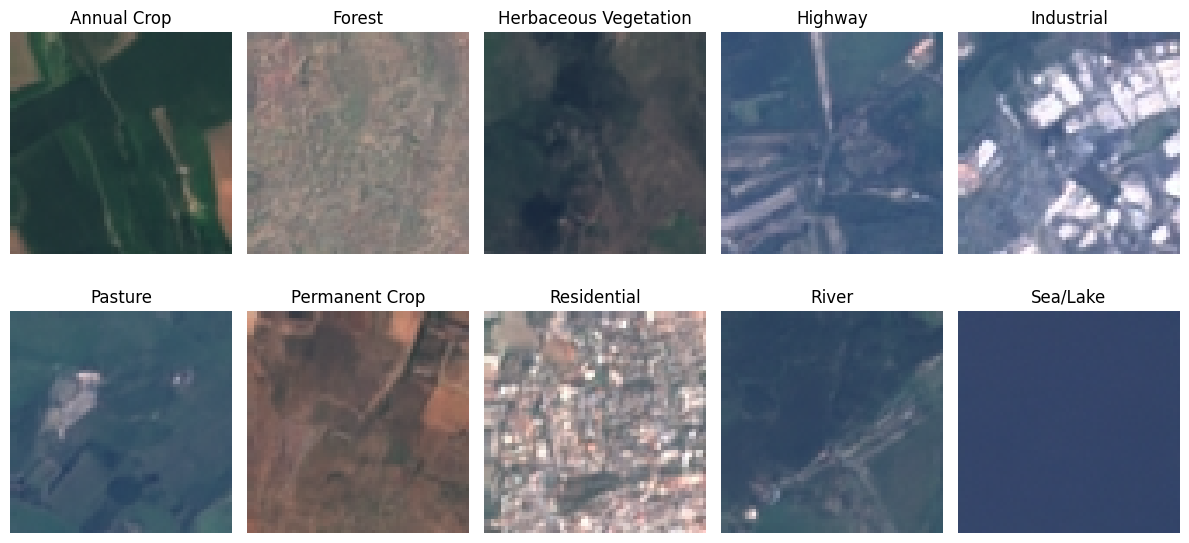

In [ ]:
noise_scheduler.set_timesteps(500)  # Sample using 500 steps!

labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device="cuda")


start_time = time.time()
images = generate_class_conditional_images(model, noise_scheduler, class_labels=labels)
end_time = time.time()

elapsed = end_time - start_time
print(f"500 timesteps: Image generation took {elapsed:.2f} seconds ({elapsed / 60:.2f} minutes)")#

batch_size = len(labels)



eurosat_classes = [
    "Annual Crop", "Forest", "Herbaceous Vegetation", "Highway",
    "Industrial", "Pasture", "Permanent Crop", "Residential",
    "River", "Sea/Lake"
]

fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i in range(batch_size):
    img = transforms.ToPILImage()(images[i].cpu())
    class_name = eurosat_classes[labels[i].item()]
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(class_name)
    axs[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()



**250 steps**

🕒 250 Steps: Image generation took 22.61 seconds (0.38 minutes)


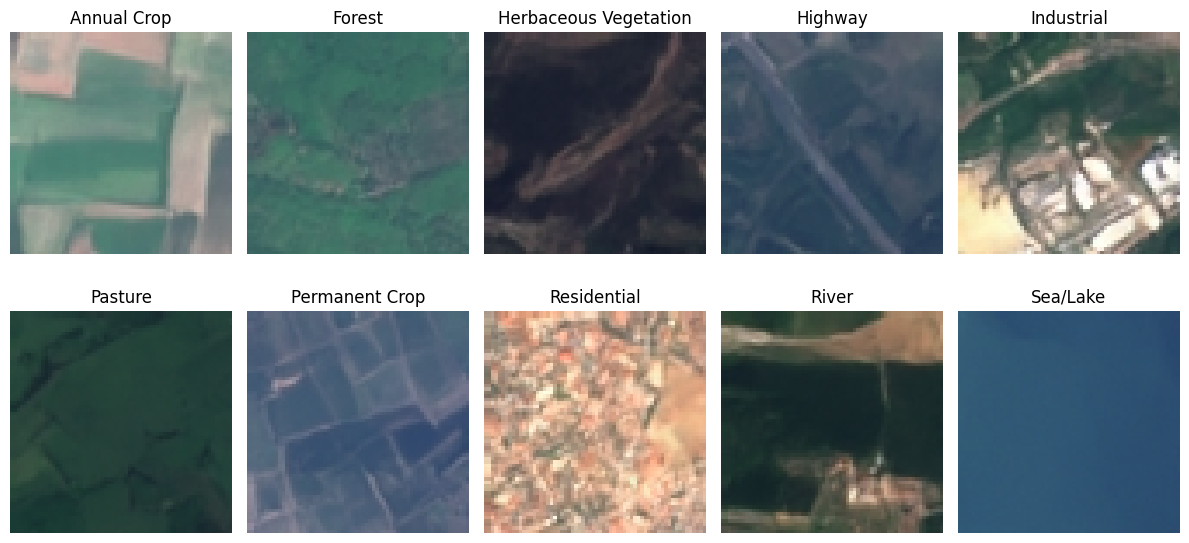

In [ ]:
noise_scheduler.set_timesteps(250)  # Sample using 250 steps!

labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device="cuda")


start_time = time.time()
images = generate_class_conditional_images(model, noise_scheduler, class_labels=labels)
end_time = time.time()

elapsed = end_time - start_time
print(f"🕒 250 Steps: Image generation took {elapsed:.2f} seconds ({elapsed / 60:.2f} minutes)")#

batch_size = len(labels)



eurosat_classes = [
    "Annual Crop", "Forest", "Herbaceous Vegetation", "Highway",
    "Industrial", "Pasture", "Permanent Crop", "Residential",
    "River", "Sea/Lake"
]

fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i in range(batch_size):
    img = transforms.ToPILImage()(images[i].cpu())
    class_name = eurosat_classes[labels[i].item()]
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(class_name)
    axs[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()



**100 steps**

🕒 100 Timesteps: Image generation took 9.09 seconds (0.15 minutes)


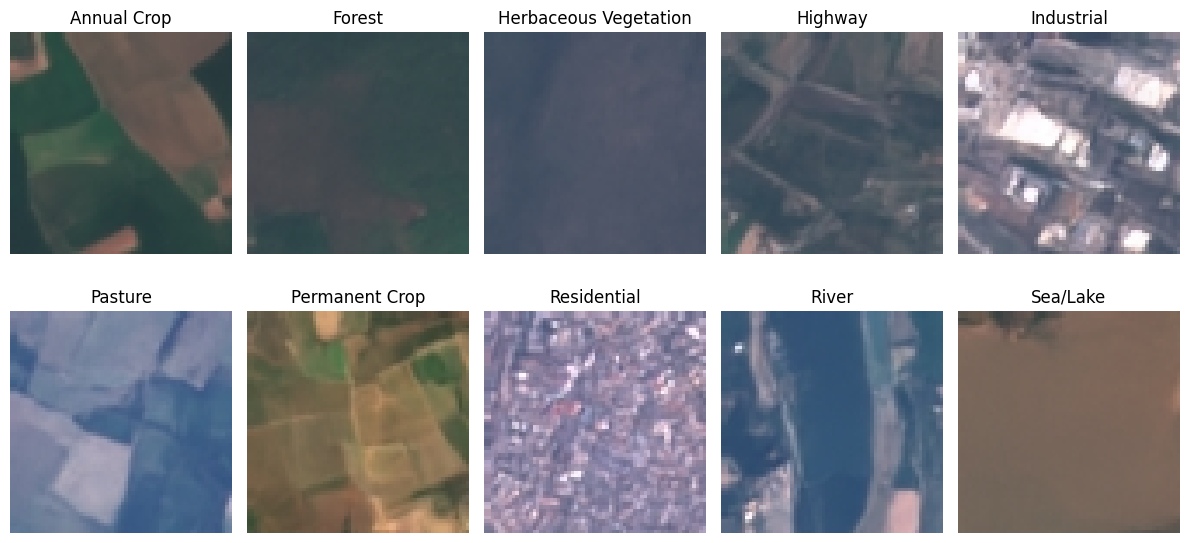

In [ ]:
noise_scheduler.set_timesteps(100)  # Sample using only 100 steps!

labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device="cuda")


start_time = time.time()
images = generate_class_conditional_images(model, noise_scheduler, class_labels=labels)
end_time = time.time()

elapsed = end_time - start_time
print(f"100 Timesteps: Image generation took {elapsed:.2f} seconds ({elapsed / 60:.2f} minutes)")#

batch_size = len(labels)



eurosat_classes = [
    "Annual Crop", "Forest", "Herbaceous Vegetation", "Highway",
    "Industrial", "Pasture", "Permanent Crop", "Residential",
    "River", "Sea/Lake"
]

fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i in range(batch_size):
    img = transforms.ToPILImage()(images[i].cpu())
    class_name = eurosat_classes[labels[i].item()]
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(class_name)
    axs[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()



## Mass Upload

In [6]:
import os
def get_last_index(folder):
    """Returns the max image index found in folder, or -1 if empty."""
    if not os.path.exists(folder):
        print(f"Folder does not exist: {folder}")
        return -1

    files = [f for f in os.listdir(folder) if f.endswith(".jpg")]
    if not files:
        print(f" Folder exists but has no .jpg files: {folder}")
        return -1

    indices = []
    for fname in files:
        try:
            index = int(fname.split(".")[0])
            indices.append(index)
        except ValueError:
            continue

    return max(indices) if indices else -1


Now let's save them inside the output folder instead of plotting them:

In [5]:
import torch
from torchvision.utils import save_image
from tqdm import tqdm
import os

def generate_class_conditional_images(model, noise_scheduler, num_images=5000, image_size=64, device="cuda"):
    eurosat_classes = [
        "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway",
        "Industrial", "Pasture", "PermanentCrop", "Residential",
        "River", "SeaLake"
    ]

    model.eval()
    images_to_generate = num_images // 10  # generate this many *new* images per class
    batch_size = 200
    os.makedirs("output", exist_ok=True)

    for label in tqdm(range(10), desc="Generating classes"):
        output_dir = os.path.join("output", eurosat_classes[label])
        os.makedirs(output_dir, exist_ok=True)

        start_idx = get_last_index(output_dir) + 1
        print(f"{eurosat_classes[label]} has {start_idx} images — generating {images_to_generate} more (→ total {start_idx + images_to_generate})")

        num_batches = (images_to_generate + batch_size - 1) // batch_size

        for batch_idx in tqdm(range(num_batches), desc=f"Class {eurosat_classes[label]}", leave=True):
            generator = torch.Generator(device=device).manual_seed(label * 100 + batch_idx + start_idx // batch_size)
            noise = torch.randn(batch_size, 3, image_size, image_size, device=device, generator=generator)
            class_labels = torch.full((batch_size,), label, device=device, dtype=torch.long)

            x = noise
            for t in noise_scheduler.timesteps:
                timesteps = torch.full((batch_size,), t, device=device, dtype=torch.long)
                with torch.no_grad():
                    noise_pred = model(x, timesteps, class_labels=class_labels).sample
                x = noise_scheduler.step(noise_pred, t, x).prev_sample

            x = (x / 2 + 0.5).clamp(0, 1)

            for i in range(batch_size):
                img_idx = start_idx + batch_idx * batch_size + i
                if i + batch_idx * batch_size >= images_to_generate:
                    break
                save_path = os.path.join(output_dir, f"{img_idx}.jpg")
                save_image(x[i], save_path)

    print("All new images generated and saved.")


To continue generating:

In [15]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
#unzip archive

shutil.unpack_archive("/content/drive/MyDrive/data/ddpm-generated-images.zip", "/content/output")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
generate_class_conditional_images(model, noise_scheduler)

Generating classes:   0%|          | 0/10 [00:00<?, ?it/s]

AnnualCrop has 2600 images — generating 500 more (→ total 3100)



Generating classes:  10%|█         | 1/10 [08:23<1:15:31, 503.53s/it]

Forest has 2600 images — generating 500 more (→ total 3100)



Generating classes:  20%|██        | 2/10 [16:46<1:07:06, 503.34s/it]

HerbaceousVegetation has 2600 images — generating 500 more (→ total 3100)



Generating classes:  30%|███       | 3/10 [25:10<58:43, 503.32s/it]  

Highway has 2600 images — generating 500 more (→ total 3100)



Generating classes:  40%|████      | 4/10 [33:33<50:19, 503.30s/it]

Industrial has 2600 images — generating 500 more (→ total 3100)



Generating classes:  50%|█████     | 5/10 [41:56<41:56, 503.31s/it]

Pasture has 2600 images — generating 500 more (→ total 3100)



Generating classes:  60%|██████    | 6/10 [50:19<33:33, 503.26s/it]

PermanentCrop has 2600 images — generating 500 more (→ total 3100)



Generating classes:  70%|███████   | 7/10 [58:41<25:07, 502.64s/it]

Residential has 2600 images — generating 500 more (→ total 3100)



Generating classes:  80%|████████  | 8/10 [1:07:04<16:45, 502.74s/it]

River has 2600 images — generating 500 more (→ total 3100)



Generating classes:  90%|█████████ | 9/10 [1:15:27<08:23, 503.00s/it]

SeaLake has 2600 images — generating 500 more (→ total 3100)



Generating classes: 100%|██████████| 10/10 [1:23:51<00:00, 503.10s/it]

All new images generated and saved.


**Uploading to drive**

In [17]:
import shutil
# Archive the folder
shutil.make_archive("ddpm-generated-images", 'zip', 'output')
print(os.path.exists("ddpm-generated-images.zip"))  # Should print: True
print(os.path.exists("/content/drive/MyDrive/data"))
# Define destination path
destination = "/content/drive/MyDrive/data/ddpm-generated-images.zip"



# Move the file
shutil.move("ddpm-generated-images.zip", destination)
print(f"Archive moved to: {destination}")

True
True
Archive moved to: /content/drive/MyDrive/data/ddpm-generated-images.zip


In [18]:
categories = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway",
    "Industrial", "Pasture", "PermanentCrop", "Residential",
    "River", "SeaLake"
]

# Count total images in all output subdirectories
total_images = 0
output_dir = 'output'

# Loop through each category folder and count images
for category in categories:
    category_path = os.path.join(output_dir, category)
    if os.path.exists(category_path):
        category_count = 0
        for root, dirs, files in os.walk(category_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    category_count += 1
                    total_images += 1
        print(f"Images in {category}: {category_count}")

Images in AnnualCrop: 3100
Images in Forest: 3100
Images in HerbaceousVegetation: 3100
Images in Highway: 3100
Images in Industrial: 3100
Images in Pasture: 3100
Images in PermanentCrop: 3100
Images in Residential: 3100
Images in River: 3100
Images in SeaLake: 3100
